Данный ноутбук представляет собой небольшое исследование применения алгоритмов многокритериальной оптимизации для задачи оптимизации криптовалютного портфеля.

In [38]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.moead import MOEAD

from pymoo.optimize import minimize

import numpy as np
import pandas as pd
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

sns.set_style('darkgrid')

In [29]:
TICKERS = ["TON11419-USD", "SUI20947-USD",'ETH-USD', "LINK-USD", "APT21794-USD", "FET-USD", "TAO22974-USD", 'BTC-USD']
data = yf.download(TICKERS, start="2024-11-01", end="2024-11-25", progress=False)["Adj Close"]

returns = data.pct_change().dropna()

expected_returns = returns.median()
cov_matrix = returns.cov()

In [30]:
class CryptoPortfolioProblem(ElementwiseProblem):
    def __init__(self, elementwise=True, **kwargs):
        n_assets = len(TICKERS)
        super().__init__(elementwise,
                        n_var=n_assets,
                        n_obj=2,
                        n_ieq_constr=1,
                        xl=0,
                        xu=1)
        
    def _evaluate(self, x, out, *args, **kwargs):
        weights = np.array(x / np.sum(x))
        profit = self.calc_profit(weights) # - чтобы максимизировать
        risk = self.calc_risk(weights)
        
        g1 = np.sum(weights) - 1
        
        out["F"] = [-profit, risk]
        out["G"] = [g1]
        
    def calc_profit(self, weights: np.ndarray) -> float:
        portfolio_return = np.sum(expected_returns * weights)
        return portfolio_return
    
    def calc_risk(self, weights: np.ndarray, confidence_level: float = 0.95) -> float:
        portfolio_mean = np.sum(expected_returns * weights)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        z_score = norm.ppf(1 - confidence_level)
        var = -(portfolio_mean + z_score * portfolio_std)
        return var  # Минимизируем VaR

In [ ]:
problem = CryptoPortfolioProblem()

algorithm = NSGA2(pop_size=100)

result = minimize(
    problem,
    algorithm,
    ('n_gen', 400),
    seed=1,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      5 |  0.000000E+00 |  8.881784E-18 |             - |             -
     2 |      200 |      5 |  0.000000E+00 |  0.000000E+00 |  1.2559608497 |         nadir
     3 |      300 |      5 |  0.000000E+00 |  0.000000E+00 |  0.9950193474 |         ideal
     4 |      400 |     10 |  0.000000E+00 |  0.000000E+00 |  0.2550487004 |         ideal
     5 |      500 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0933834368 |         ideal
     6 |      600 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0367056551 |         ideal
     7 |      700 |      7 |  0.000000E+00 |  0.000000E+00 |  0.1626797417 |         ideal
     8 |      800 |     10 |  0.000000E+00 |  0.000000E+00 |  0.1628704783 |         ideal
     9 |      900 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0494123475 |             f
    10 |     1000 |      8 |  0.000000E+00 |  0.000000E+00 |  0.1231011450 |         ideal

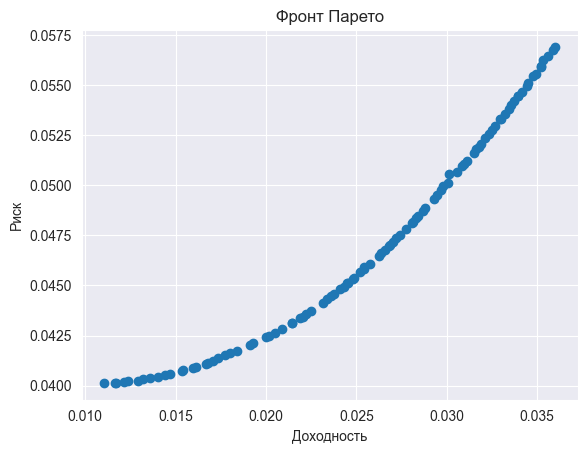

In [34]:
plt.scatter(-result.F[:, 0], result.F[:, 1])
plt.xlabel("Доходность")
plt.ylabel("Риск")
plt.title("Фронт Парето")
plt.show()

In [40]:
problem = CryptoPortfolioProblem()
algorithm2 = MOEAD(n_neighbors=20)

result = minimize(
    problem,
    algorithm2,
    ('n_gen', 200),
    seed=1,
    verbose=True
)


TypeError: object of type 'NoneType' has no len()